# Figure 4

imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
#print(os.getcwd())

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
import torch, os, sys
import seaborn as sns
from utils.funcs import *
from boltzmann_machines.RTRBM import RTRBM
#from boltzmann_machines.RBM import RBM
from utils.poisson_surrogate_data import PoissonTimeShiftedData
from matplotlib.colors import LogNorm, LinearSegmentedColormap

from scipy.stats import pearsonr
from scipy.signal import correlate2d
from matplotlib.ticker import LogFormatterExponent

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

path2dir  = os.getcwd()

In this notebook we inspect the ability of the RTRBM to extract temporal dynamics of neural assemblies as a function of the interaction time. We hypothesise it is crucial to sample the data at the right frequency, such that most interactions happen at the same delay as the sampling. We test this by creating surrogate data that has temporal interactions with a delay of 4 time-steps. By down-sampling this data, training RTRBMs and quantifying their reconstruction performance we test this hypothesis.

In [3]:
n_h = 10 # number of populations and hidden units
neurons_per_population = 20 # number of neurons per population
delay = 4 # population interaction delay

U_original = 0.7 * create_U_hat(n_h) # noticable but decaying connection. *1 = sustained feedback, >1 = positive feedback loop

int_range = [5, 10]  # interval range external input
max_fr = 0.6 # max firing rate of external input
std_range = [0.1, 0.5] # width of gaussian shaped peaks of external input

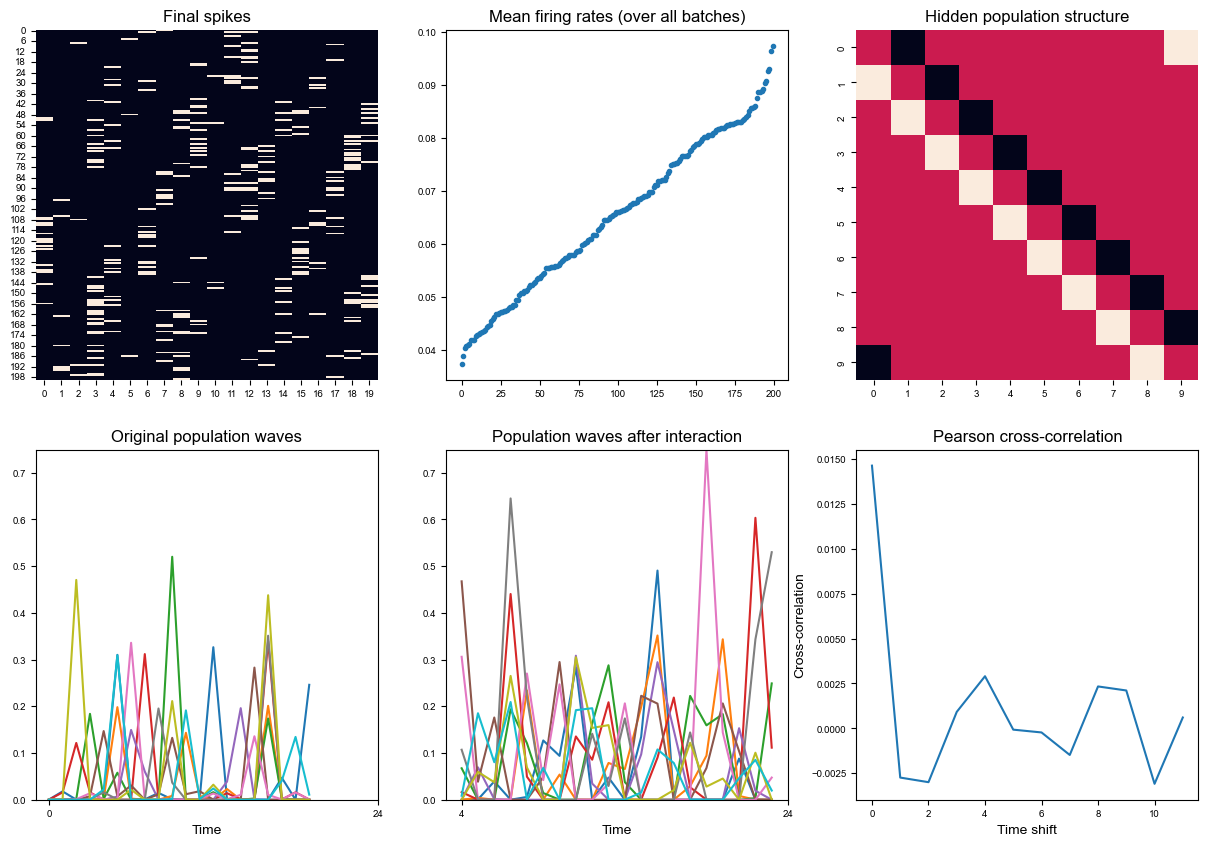

In [5]:
s = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=50,
    time_steps_per_batch=100, steps_to_settle=25,
    delay=delay, U=U_original,
    int_range=int_range, max_fr=max_fr, std_range=std_range, seed=1,
)


axes = s.plot_stats(T=20)
plt.show()

# Training

In [6]:
rtrbm_list = []

if False:#not os.path.isfile(path2dir + '/models/figure4_downsampling/run10/downsampled10/rtrbm'):
    # perform 10 runs
    for run in range(10):
        n_h = 10 # number of populations and hidden units
        neurons_per_population = 20 # number of neurons per population
        delay = 4 # population interaction delay
        
        U_original = 0.7 * create_U_hat(n_h) # noticable but decaying connection. *1 = sustained feedback, >1 = positive feedback loop
        
        int_range = [5, 10]  # interval range external input
        max_fr = 0.6 # max firing rate of external input
        std_range = [0.1, 0.5] # width of gaussian shaped peaks of external input
        
        # create data
        s = PoissonTimeShiftedData(
            neurons_per_population=neurons_per_population,
            n_populations=n_h, n_batches=500,
            time_steps_per_batch=1000, steps_to_settle=25, # 1000 time steps, as max ds rate is 10
            delay=delay, U=U_original,
            int_range=int_range, max_fr=max_fr, std_range=std_range,
            seed=run)

        # down-sample data by 1, 2, ..., 10
        for d in tqdm(range(1, 11)):

            # perform down sampling, only take 50000 time-steps
            data = resample(reshape(s.data.detach().clone()), sr=d, mode=2)[:, :50000]

            # reshape data to batches
            data = reshape(data, T=20, n_batches=2500)

            # take 2000 train batches and 500 test batches
            train, test = data[..., :2000], data[..., 2000:]

            # initialize and train RTRBM
            rtrbm = RTRBM(train, n_hidden=n_h, device='cuda')
            rtrbm.learn(batch_size=10, n_epochs=500, CDk=15, mom=0.9, wc=0.0002, disable_tqdm=True,
                        lr_schedule='geometric_decay', min_lr=5e-4, max_lr=1e-3)

            # save list
            torch.save(rtrbm, path2dir + '/models/figure4_downsampling/run%s/downsampled%s/rtrbm'%(run+1, d))
            torch.save(train, path2dir + '/data/figure4_downsampling/run%s/downsampled%s/train'%(run+1, d))
            torch.save(test, path2dir + '/data/figure4_downsampling/run%s/downsampled%s/test'%(run+1, d))

            rtrbm_list += [rtrbm]
else:
    for n in range(1, 11):
        for d in range(1, 11):
            device = torch.device('cpu')
            rtrbm_list += [torch.load(path2dir + '/data/figure4_downsampling/run%s/downsampled%s/rtrbm'%(n, d), map_location=device)]

## Show U matrices

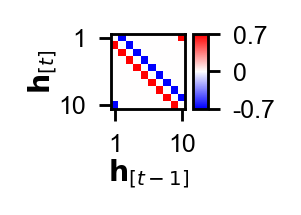

In [8]:
# Show original U matrix used in interactions
plt.figure(figsize = (1, 1), dpi=256, layout='constrained')
extent = [0.5, 10.5, 10.5, 0.5]
img = plt.imshow(U_original, cmap='bwr', extent=extent)
plt.gca().set_xticks([1, 10], [1, 10], fontsize=7)
plt.gca().set_yticks([1, 10], [1, 10], fontsize=7)

plt.gca().set_xlabel('$\mathbf{h}_{[t-1]}$', fontsize=8, labelpad=0)
plt.gca().set_ylabel('$\mathbf{h}_{[t]}$', fontsize=8, labelpad=0)

cax = plt.gca().inset_axes([10.5 + 1, 0.5, 2, 10], transform=plt.gca().transData)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.set_yticks([-0.7, 0, 0.7], [-0.7, 0, 0.7], fontsize=7)

#plt.savefig('images/U_original.svg')
plt.show()

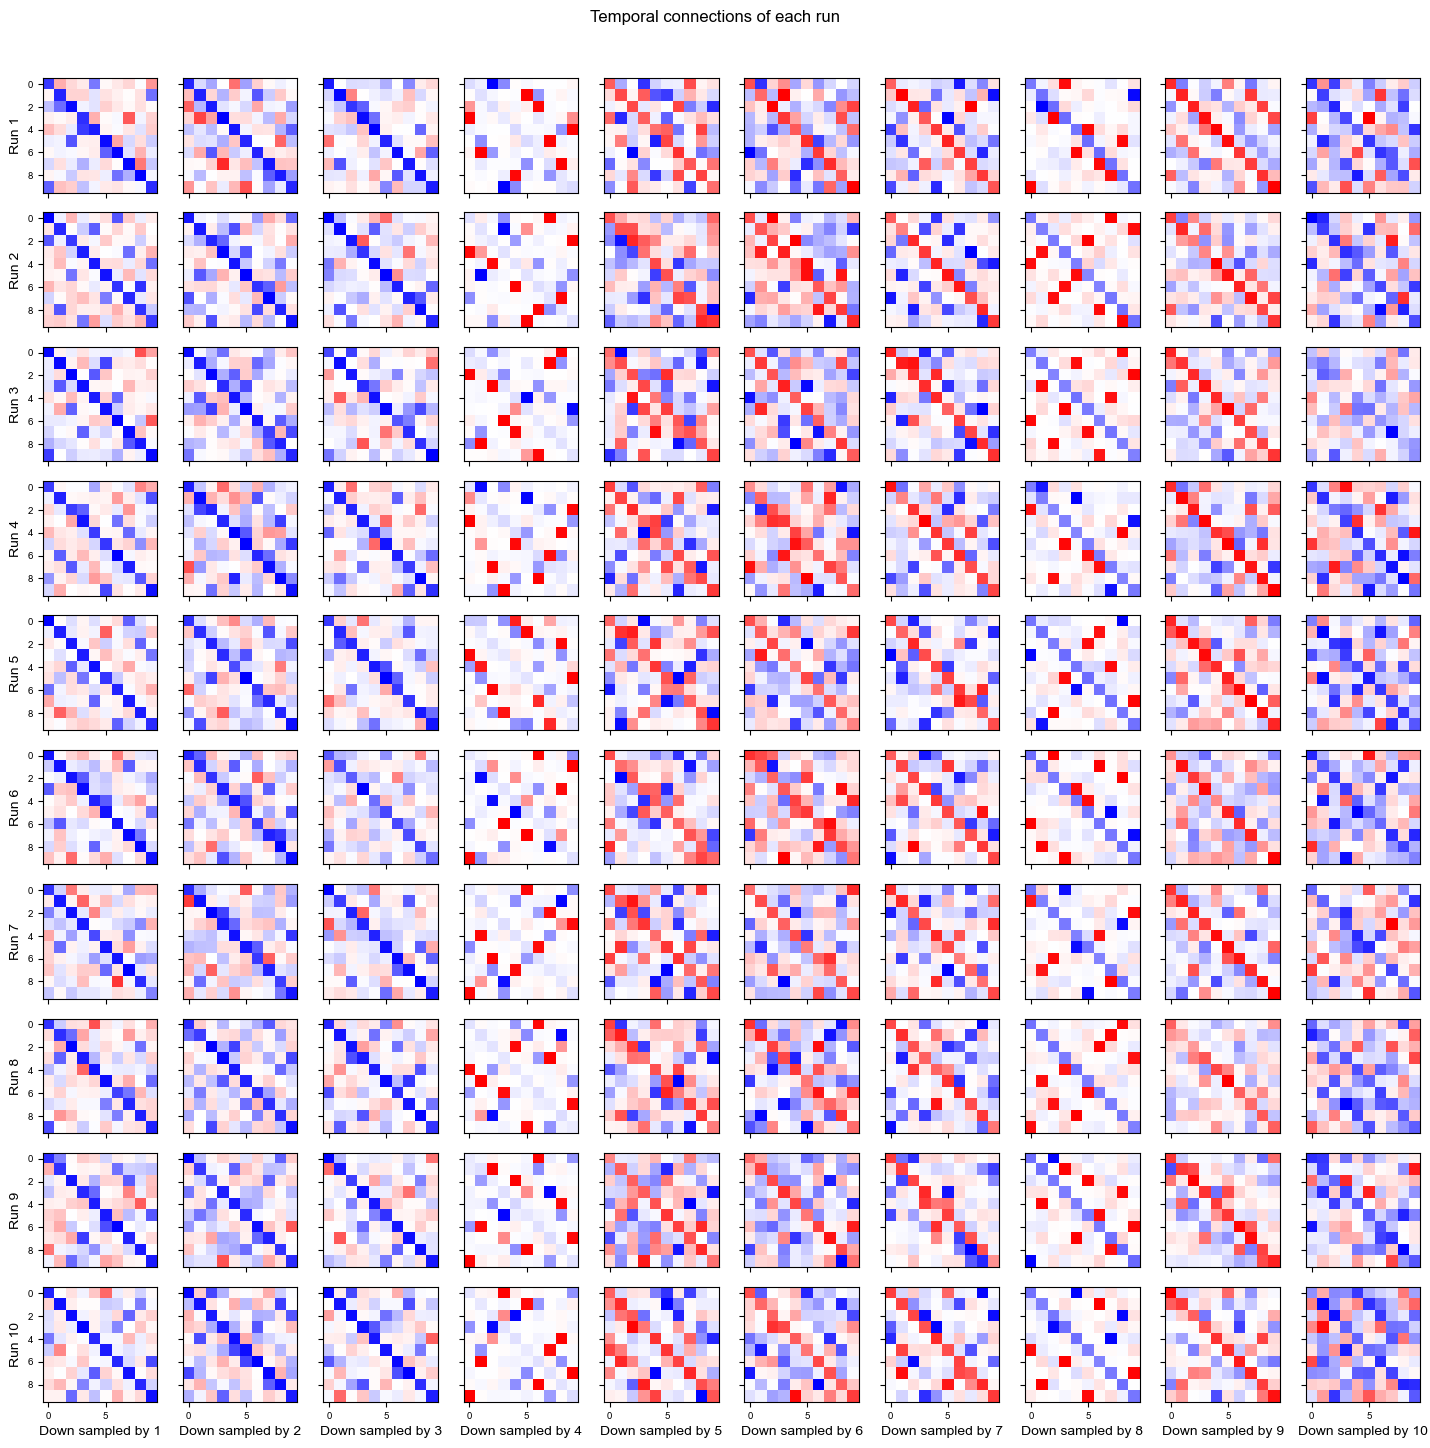

In [9]:
# Show learned U matrices
fig, axs = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):

    W_trained, U_trained = rtrbm.W.cpu(), rtrbm.U.cpu()
    lim = float(np.abs(U_trained).max())
    ax.imshow(U_trained, cmap=plt.get_cmap('bwr'), vmin=-lim, vmax=lim)

    row = i // 10
    col = i % 10
    if col == 0:
        ax.set_ylabel('Run %d' % (row + 1))
    if row == 9:
        ax.set_xlabel('Down sampled by %d' % (col + 1))

fig.suptitle('Temporal connections of each run')
plt.tight_layout(pad=3, h_pad=1.08, w_pad=1.08)

plt.show()

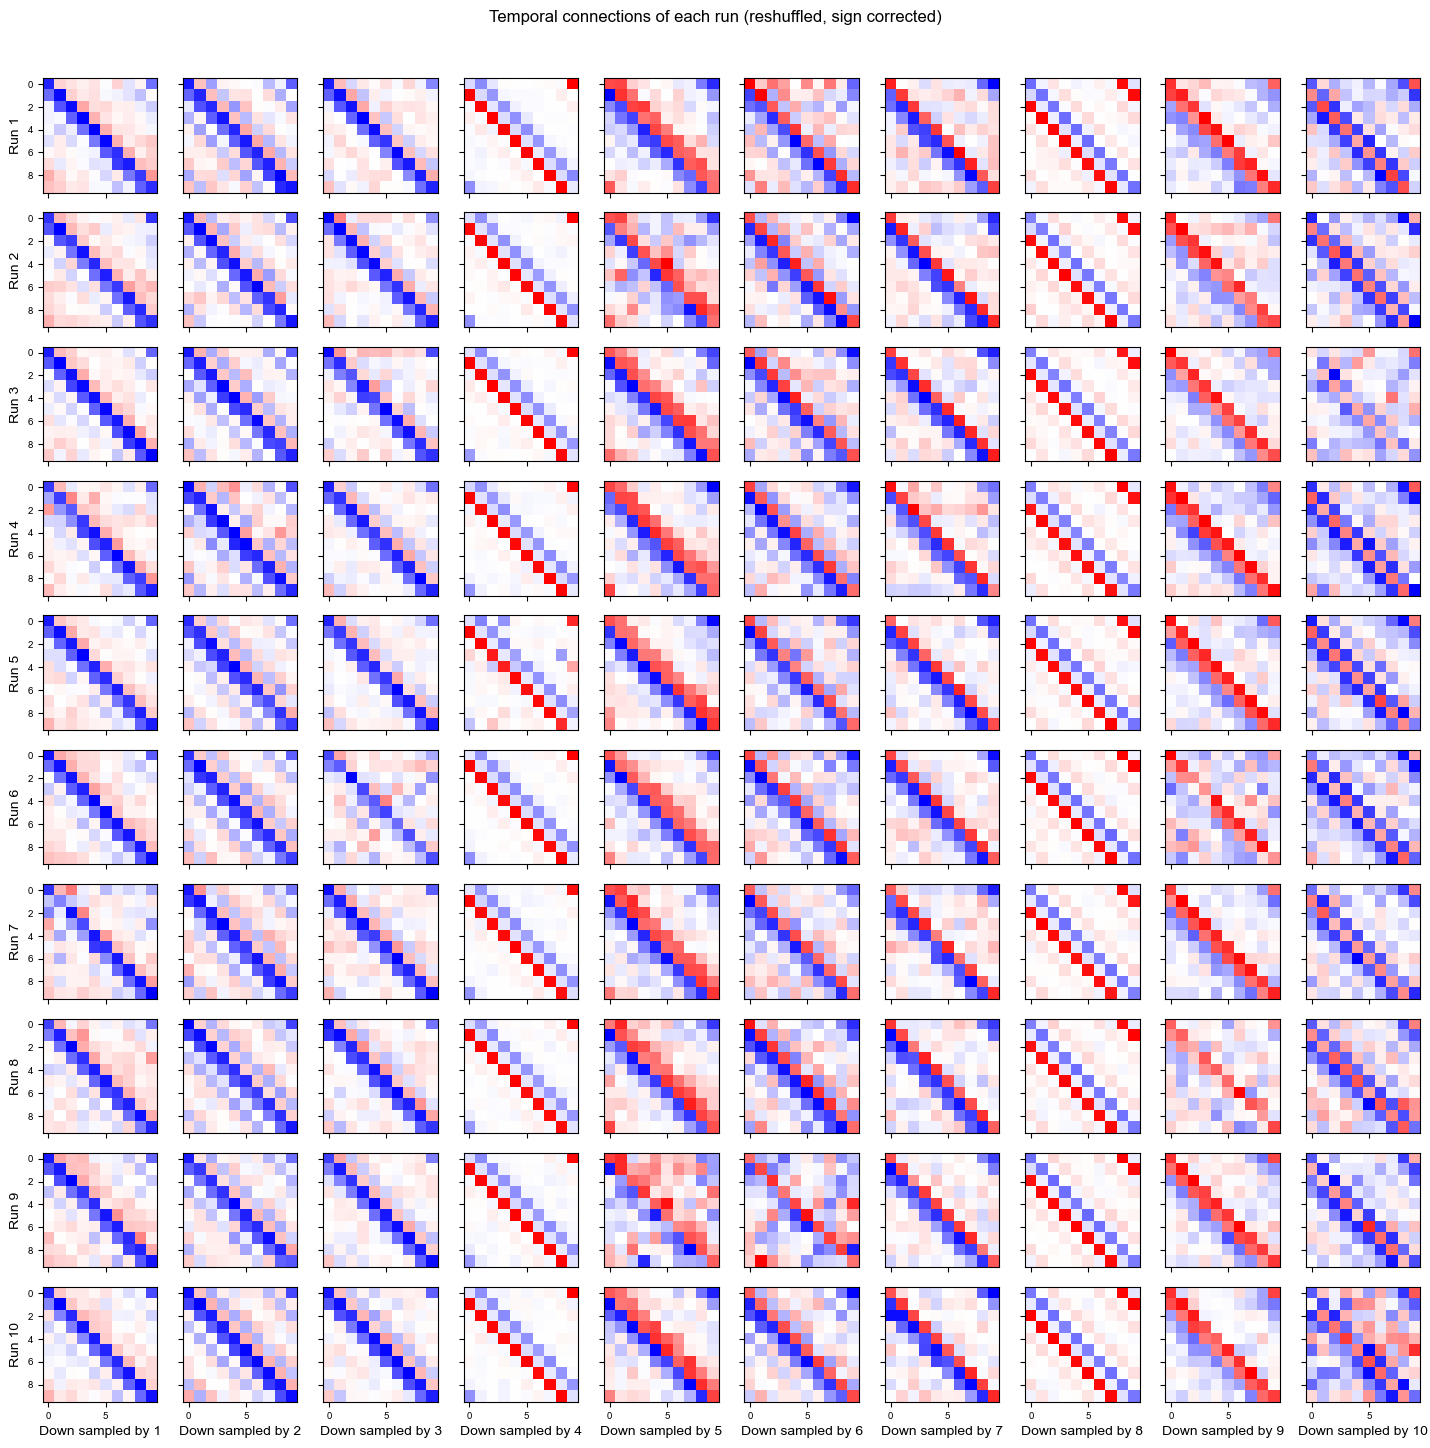

In [10]:
# Reshuffled (without duplicates), with sign correction
fig, axs = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True)

W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
n_h, n_v = W_hat.shape
neurons_per_population = n_v // n_h 

for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1

for i, (rtrbm, ax) in enumerate(zip(rtrbm_list, axs.flatten())):
    try:
        W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    except:
        continue
    # correct the U signs
    unit_signs = np.empty(n_h, dtype='int')
    
    for unit in range(n_h):
        # mean of population
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
        unit_signs[unit] = np.sign(mean_weight)
    
    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    
    # plot the result
    lim = float(np.abs(U_trained).max())
    
    ax.imshow(U_trained, cmap=plt.get_cmap('bwr'), vmin=-lim, vmax=lim)

    row = i // 10
    col = i % 10
    if col == 0:
        ax.set_ylabel('Run %d' % (row + 1))
    if row == 9:
        ax.set_xlabel('Down sampled by %d' % (col + 1))

fig.suptitle('Temporal connections of each run (reshuffled, sign corrected)')
plt.tight_layout(pad=3, h_pad=1.08, w_pad=1.08)

plt.show()

**Sampling from trained model to (somewhat) validate sign correction**

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.31it/s]


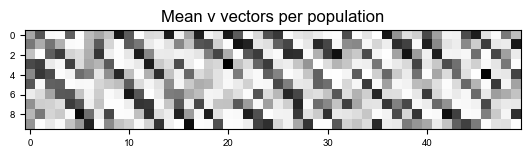

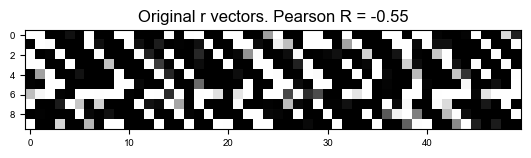

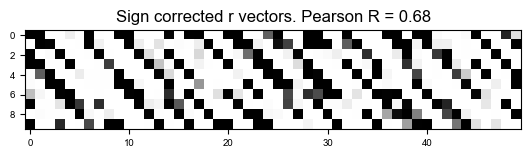

In [15]:
n_v = n_h*neurons_per_population

rtrbm = rtrbm_list[33]

rtrbm.device = 'cpu'

v_start = torch.zeros(n_v)
v_start[:] = 1
v_output, r_output = rtrbm.sample(v_start, chain=50, pre_gibbs_k=400, gibbs_k=100, mode=2)

T = v_output.shape[1]
meaned_output = np.empty([n_h, T])

for i in range(n_h):
    meaned_output[i] = v_output[(i*neurons_per_population):((i+1)*neurons_per_population), :, 0].mean(axis=0)

#plt.imshow(v_output[:, :, 0], cmap='binary')
plt.imshow(meaned_output, cmap='binary')
plt.title('Mean v vectors per population')
plt.show()

# Find aligned ordering of populations
W = rtrbm.W.cpu()
U = rtrbm.U.cpu()
W_trained, U_trained = shuffle_back(W, U, W_true=W_hat, allow_duplicates = False)

shuffle = np.empty(n_h, dtype='int')
for i in range(n_h):
    shuffle[i] = np.where(W[:, 0] == W_trained[i, 0])[0][0]

# correct the U signs
unit_signs = np.empty(n_h, dtype='int')

for unit in range(n_h):
    # mean of associated visible units
    mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
    
    unit_signs[unit] = np.sign(mean_weight)
    
# Reorder r accordingly
r = np.array(r_output[shuffle, :, 0])
flip = np.where(unit_signs == -1)[0]

r_flipped = r.copy()
r_flipped[flip] = 1 - r_flipped[flip]


plt.imshow(r, cmap='binary')
corr = np.corrcoef(r.ravel(), meaned_output.ravel())[0, 1]
plt.title("Original r vectors. Pearson R = {:.2f}".format(corr))
plt.show()

plt.imshow(r_flipped, cmap='binary')
corr = np.corrcoef(r_flipped.ravel(), meaned_output.ravel())[0, 1]
plt.title("Sign corrected r vectors. Pearson R = {:.2f}".format(corr))
plt.show()

## Similarity between $U$ and $\hat{U}$

In [12]:
# Calculate cosine similarity
    
def cosine_similarity(A, B):
    return np.trace(np.matmul(A.T, B)) / (np.linalg.norm(A) * np.linalg.norm(B))



W_hat = torch.zeros_like(rtrbm_list[0].W.cpu())
for i in range(n_h):
    W_hat[i:(i+1), i*neurons_per_population:(i+1)*neurons_per_population] = 1


C = np.empty(len(rtrbm_list))
for i, rtrbm in enumerate(rtrbm_list):
    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    
    # Correct the U signs
    unit_signs = np.empty(n_h, dtype='int')
    for unit in range(n_h):
        # Population sign is taken as the sign of the mean weight
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
        unit_signs[unit] = np.sign(mean_weight)

    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    
    C[i] = cosine_similarity(U_trained, U_original)
    
C = C.reshape((n_h, n_h))

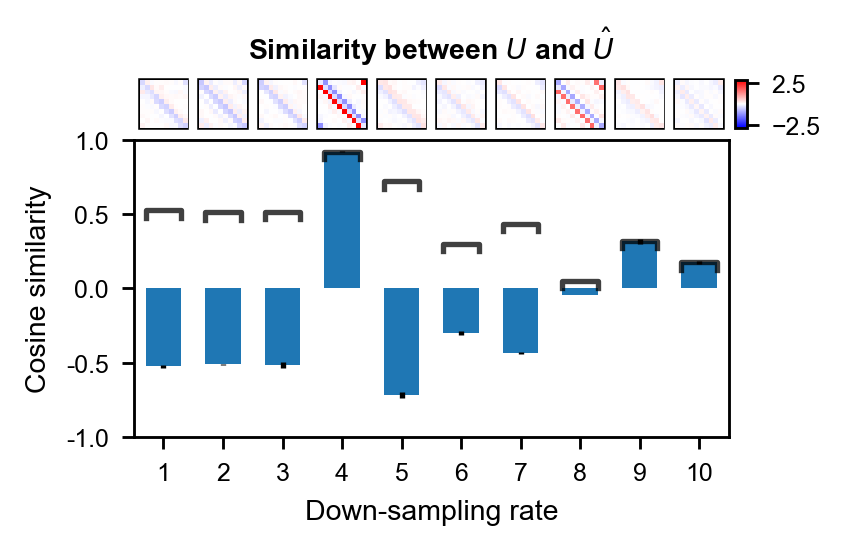

In [16]:
# Show cosine similarity and best matches
from matplotlib.patches import Rectangle

barwidth = 0.6
Uwidth = 0.8

# Plot result
fig, ax = plt.subplots(figsize = (3, 2), dpi=256)
ax.bar(np.arange(10) + 1, np.mean(C, axis=0), zorder=0, width=barwidth)
ax.errorbar(np.arange(10) + 1, np.mean(C, axis=0), np.std(C, axis=0) / np.sqrt(10), c='k', fmt=' ', zorder=2)

# Add markers indicating absolute score
for i in range(10):
    height = np.abs(np.mean(C[:, i]))
    
    x_start = i + 1 - barwidth/2
    x_end = i + 1 + barwidth/2
    
    y_start = max(0, height-0.05)
    ax.plot([x_start, x_start, x_end, x_end], [y_start, height, height, y_start], c='k', alpha=0.75, zorder=1)#, linestyle='--')

ax.set_title('Similarity between $U$ and $\hat{U}$', fontsize=8, fontweight='bold')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_ylabel('Cosine similarity', fontsize=8)
ax.set_yticks(np.arange(-1, 1.1, 0.5))
ax.set_yticklabels(np.arange(-1, 1.1, 0.5), fontsize=7)
ax.set_ylim([-1, 1])

ax.set_xlabel('Down-sampling rate', fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=7)
ax.set_xlim([0.5, 10.5])

# Calculate color lims beforehand
lim = 0
for i in range(10):
    U = rtrbm_list[i + 10*np.argmax(np.abs(C[:, i]))].U.cpu()
    highest = torch.max(torch.abs(U))
    if highest > lim:
        lim = highest
    
# Add trained U matrices
for i in range(10):
    
    # NOTE: For some where ds != 4, the best performing model has a non-nice structure, whereas the
    # worst performing ones do have a nice structure. This is thus not a fair visual comparison,
    # as this way it looks like the other ds rates are not able to find any structure.
    
    # Because of this, the U matrices with the largest correlation are shown instead,
    # which are more representative of the learned matrices
    
    #rtrbm = rtrbm_list[i + 10*np.argmin(test_errors[i])] # best performance comparison
    rtrbm = rtrbm_list[i + 10*np.argmax(np.abs(C[:, i]))] # best visual comparison
    U = rtrbm.U.cpu()

    W_trained, U_trained = shuffle_back(rtrbm.W.cpu(), rtrbm.U.cpu(), W_true=W_hat, allow_duplicates=False)
    
    # correct the U signs
    unit_signs = np.empty(n_h, dtype='int')

    for unit in range(n_h):
        # mean of population
        mean_weight = W_trained[unit:(unit+1), unit*neurons_per_population:(unit+1)*neurons_per_population].mean()
        unit_signs[unit] = np.sign(mean_weight)

    U_trained = U_trained * np.outer(unit_signs, unit_signs)
    

    aspect = 10 / 4
    offset = (1 - Uwidth)/aspect # offset above figure
    
    extent = [i+1 - (Uwidth/2), i+1 + (Uwidth/2), 1 + offset, 1 + offset + Uwidth/aspect]
    img = ax.imshow(U_trained, vmin=-lim, vmax=lim, cmap='bwr', interpolation='none', extent=extent, clip_on=False, zorder=1)
    ax.add_patch(Rectangle([extent[0], extent[2]], width=Uwidth, height=Uwidth/aspect, edgecolor='k', facecolor='none', clip_on=False, zorder=0))

cax = ax.inset_axes([extent[0] + 1, extent[2], 0.2, Uwidth/aspect], transform=ax.transData)
cbar = fig.colorbar(img, cax=cax, ticks=[-2.5, 2.5])
    
ax.set_aspect(aspect)
#plt.savefig('images/cosine_similarity.svg')#, dpi=256)
plt.show()

# Test error

In [22]:
%%time
# Generate own test data, for consistency
s_test = PoissonTimeShiftedData(
    neurons_per_population=neurons_per_population,
    n_populations=n_h, n_batches=1000,
    time_steps_per_batch=1000, steps_to_settle=25,
    delay=delay, U=U_original,
    int_range=int_range, max_fr=max_fr, std_range=std_range,
    seed=0) # fixed seed

test_data = s_test.data.detach().clone()

CPU times: total: 5min 30s
Wall time: 59.8 s


In [6]:
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [6]:
#####################################################################
# THIS CODE CALCULATES ALL TEST ERRORS AND TAKES QUITE LONG TO RUN. #
# SEE BELOW TO IMPORT PRE-CALCULATED TEST ERRORS                    #
#####################################################################

test_accuracy = np.empty([10, 10]) # shape (ds rates, models)
theoretical_accuracy = np.empty([10]) # error depends on the distribution of test data, so is different for each ds rate

device = torch.device('cpu')
CDk = 40 # seems to be a more stable number of iterations. At 20 the error is still increasing for most models

# While it is possible to run this on the gpu instead of the cpu, it requires a lot of memory

torch.manual_seed(0)

for i, rtrbm in tqdm(enumerate(rtrbm_list), total=100):
    d = (i % 10) + 1
    n = i // 10

    n_batches_to_use = test_data.shape[2]
    
    # Reshape such that every single time point is sampled as if it was a batch
    v_data = reshape_fortran(test_data[:, ::d, :n_batches_to_use][:, :100], shape=[test_data.shape[0], 100*n_batches_to_use])
    
    if i < 10:
        p_positive = torch.mean(v_data, axis=1) # mean firing rate per neuron
        theoretical_accuracy[i] = 1 - torch.mean(2*p_positive*(1 - p_positive)) # MSE of mismatch for binary signal
        # (theoretical value is confirmed through simulation)

    
    rtrbm.device = torch.device('cpu')
    vt, rt = rtrbm.sample(v_data, chain=1, pre_gibbs_k=CDk, gibbs_k=1, disable_tqdm=True) # sample one time step ahead
    vt = vt[:, 0] # chain=1, so result can be flattened along this axis
    
    time_steps_per_batch = 100

    # Align test data with sampled data
    first_of_batch = np.arange(n_batches_to_use, dtype='int')*time_steps_per_batch
    last_of_batch = np.arange(1, n_batches_to_use + 1, dtype='int')*time_steps_per_batch - 1

    v_data_subset = np.delete(v_data, first_of_batch, axis=1)
    vt_subset = np.delete(vt, last_of_batch, axis=1)
    
    # Accuracy (this formulation only holds if both variables are binary)
    test_accuracy[d-1, n] = 1 - torch.mean(torch.abs(v_data_subset - vt_subset))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [28:08<00:00, 16.88s/it]


In [17]:
# save results
# np.save('one_step_ahead_accuracy.npy', test_accuracy)
# np.save('theoretical_accuracy.npy', theoretical_accuracy)

# load results
test_accuracy = np.load('fig_4B_one_step_ahead_accuracy.npy') # shape (n_ds, n_model)
theoretical_accuracy = np.load('fig_4B_theoretical_accuracy.npy') # shape (n_ds) # Mean firing rate per neuron


# # SEE BOTTOM OF NOTEBOOK FOR SIMULATION TO ACHIEVE THESE VALUES
acc_upper_bound = np.ones(10) * 0.8880550295
acc_upper_err = np.ones(10) * 0.0000514961

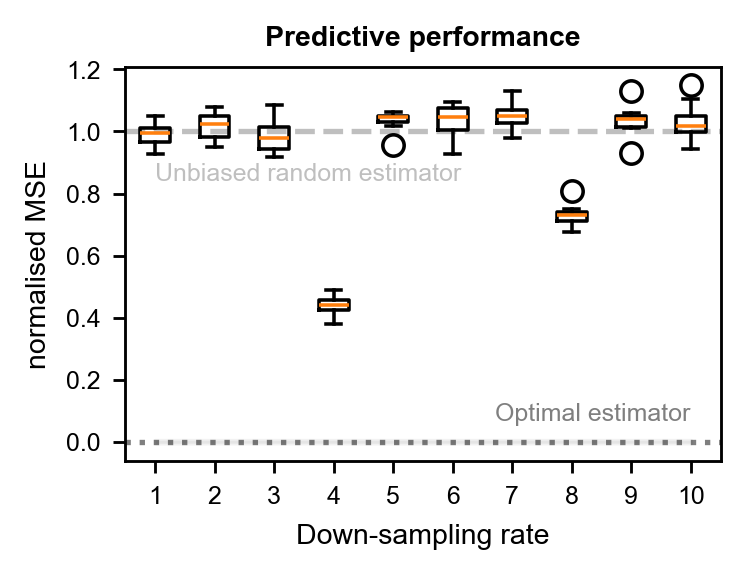

In [19]:
# Show results
fig, ax = plt.subplots(figsize = (3, 2), dpi=256)
ax.ticklabel_format(style='sci', axis='y')

# theoretical accuracy is defined per ds rate, so subtraction should be done this way
nMSE = ((test_accuracy.T - acc_upper_bound) / (theoretical_accuracy - acc_upper_bound)).T
nMSE_bound_err = acc_upper_err / (acc_upper_bound - theoretical_accuracy)
ax.boxplot(nMSE.T, positions = np.arange(10) + 1, zorder=1)

# Random process accuracy (with same <v>)
ax.axhline(1, c='k', alpha=0.25, linestyle='--', zorder=-1)
ax.text(1, 0.9, "Unbiased random estimator", fontsize=7, ha='left', va='top', alpha=0.25)

# Error due to variance in sampling when generating data
ax.axhline(0, c='k', alpha=0.5, linestyle='dotted', zorder=-1)
ax.fill_between(np.arange(10) + 1, -nMSE_bound_err, nMSE_bound_err,
              color = 'k', alpha=0.05, zorder=-2)
ax.text(10, 0.05, "Optimal estimator", fontsize=7, ha='right', va='bottom', alpha=0.5)
    
# Add significance stars
# for i in range(10):
#     if n_stars[i] > 0:

#         if n_stars[i] <= 3:
#             text = '*'*n_stars[i]
#         else:
#             text = str(n_stars[i]) + '*'

#         if i in [3, 7]: # show below
#             ax.text(i + 1, np.min(1 - test_errors[i]) - 0.0005, text, ha='center', va='top')
#         else: # show above
#             ax.text(i + 1, np.max(1 - test_errors[i]) + 0.000, text, ha='center', va='bottom')

ax.set_title('Predictive performance', fontsize=8, fontweight='bold')

ax.set_xlabel('Down-sampling rate', fontsize=8)
ax.set_xticks(np.arange(10) + 1)
ax.set_xticklabels(np.arange(10) + 1, fontsize=7)
ax.set_xlim([0.5, 10.5])

ax.set_ylabel('normalised MSE', fontsize=8)

#plt.tight_layout()

# plt.savefig('images/normalised_MSE.svg')#, dpi=256)
plt.show()

In [20]:
# Calculate p-values
from scipy.stats import mannwhitneyu as MWU
from scipy.stats import wilcoxon

n_stars = np.empty([10], dtype='int')

# Test if better than random (wilcoxon)
print("Better than random?")
for ds in range(1, 11):
    p_value = wilcoxon([theoretical_accuracy[ds-1]]*10, test_accuracy[ds-1], alternative='less')[1]
    #p_value = ttest_1samp(test_accuracy[ds-1], popmean=theoretical_accuracy[ds-1], alternative='less')[1]
    p_value *= 10 # bonferroni correction
    effect_size = (np.mean(test_accuracy[ds-1]) - theoretical_accuracy[ds-1]) / np.std(test_accuracy[ds-1], ddof=1)
    
    
    if p_value >= 0.05:
        n_stars[ds-1] = 0
    else:
        n_stars[ds-1] = int(np.floor(-np.log10(p_value)))
    
    
    if n_stars[ds-1] == 0:
        print("{}x NOT significant\tp = {:.5f}\td = {:.2f}".format(ds, p_value, effect_size))
    else:
        print("{}x  is significant{}\tp = {:.5f}\td = {:.2f}".format(ds, n_stars[ds-1]*'*', p_value, effect_size))

# Test if better than other (MWU)
compare = 4

print("\nIs {}x downsampling better?".format(compare))
for ds in range(1, 11):
    if ds == compare:
        print('--')
        continue
    
    p_value = MWU(test_accuracy[ds-1], test_accuracy[compare-1], alternative='less')[1]
    #p_value = ttest_ind(test_accuracy[ds-1], test_accuracy[compare-1], equal_var=False, alternative='greater')[1]
    p_value *= 9 # bonferroni correction
    
    pooled_s = np.sqrt((np.var(test_accuracy[ds - 1]) + np.var(test_accuracy[compare - 1]) )/2 )
    effect_size = (np.mean(test_accuracy[compare-1]) - np.mean(test_accuracy[ds-1])) / pooled_s
    
    if p_value >= 0.05:
        n_stars_ds = 0
    else:
        n_stars_ds = int(np.floor(-np.log10(p_value)))
    
#     if p_value < 0.001:
#         n_stars_ds = 3
#     elif p_value < 0.01:
#         n_stars_ds = 2
#     elif p_value < 0.05:
#         n_stars_ds = 1
#     else:
#         n_stars_ds = 0
    
    
    if n_stars_ds == 0:
        print("{}x NOT significant\tp = {:.5f}\td = {:.2f}".format(ds, p_value, effect_size))
    else:
        print("{}x  is significant{}\tp = {:.5f}\td = {:.2f}".format(ds, n_stars_ds*'*', p_value, effect_size))

Better than random?
1x NOT significant	p = 3.12500	d = 0.23
2x NOT significant	p = 8.62305	d = -0.40
3x NOT significant	p = 2.46094	d = 0.22
4x  is significant**	p = 0.00977	d = 16.24
5x NOT significant	p = 9.95117	d = -1.16
6x NOT significant	p = 9.67773	d = -0.61
7x NOT significant	p = 9.98047	d = -1.18
8x  is significant**	p = 0.00977	d = 7.61
9x NOT significant	p = 9.75586	d = -0.69
10x NOT significant	p = 9.19922	d = -0.52

Is 4x downsampling better?
1x  is significant***	p = 0.00082	d = 15.91
2x  is significant***	p = 0.00082	d = 15.37
3x  is significant***	p = 0.00082	d = 12.71
--
5x  is significant***	p = 0.00082	d = 18.91
6x  is significant***	p = 0.00082	d = 13.63
7x  is significant***	p = 0.00082	d = 16.14
8x  is significant***	p = 0.00082	d = 8.93
9x  is significant***	p = 0.00082	d = 14.76
10x  is significant***	p = 0.00082	d = 12.87


4x downsampling is better than all (p = 0.00082, effect size >= 8.93)
8x downsampling is better than all except 4 (p = 0.00082, effect size >= 5.93)

## Show downsampled test data

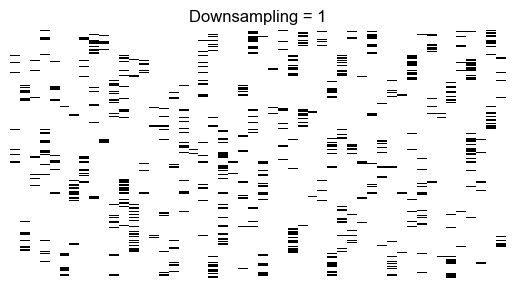

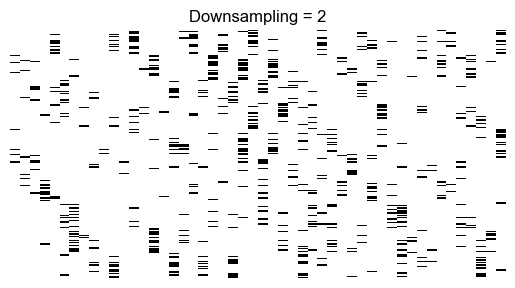

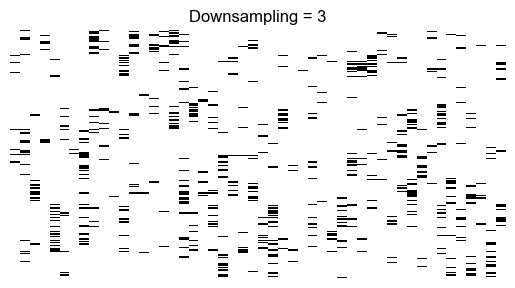

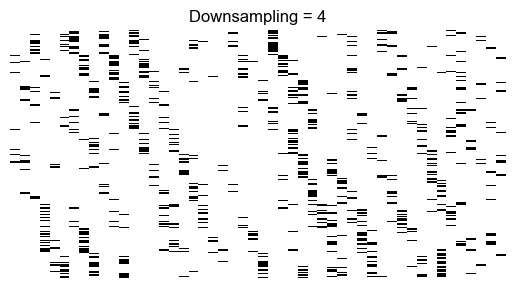

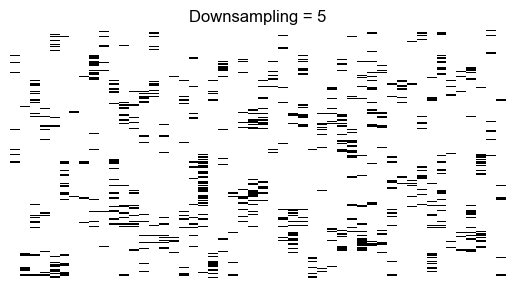

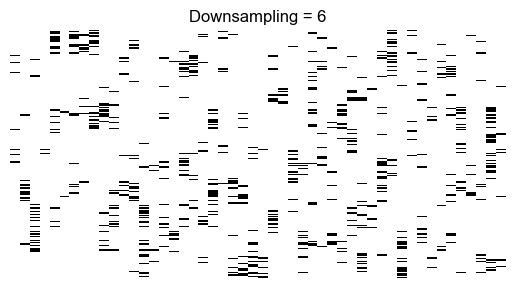

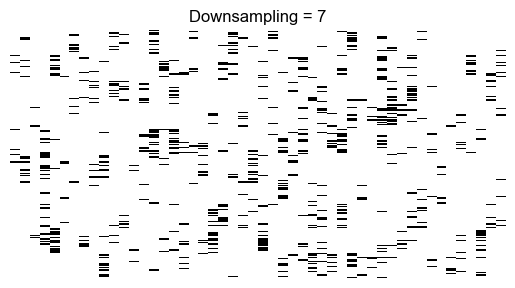

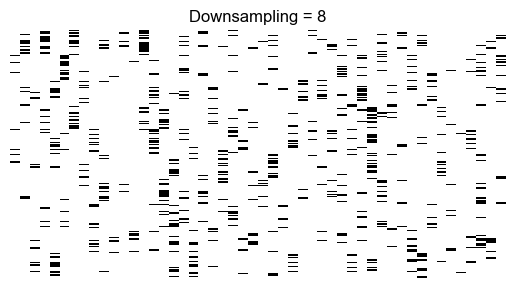

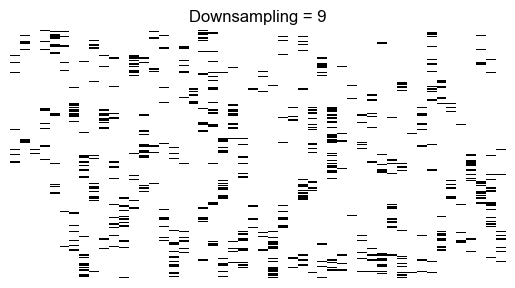

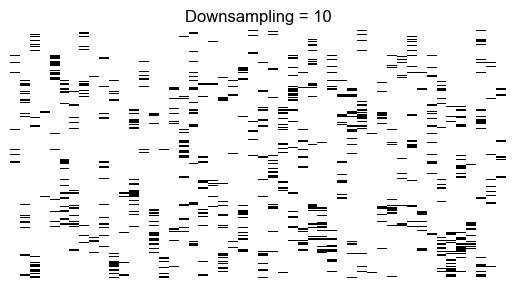

In [23]:
data = test_data[..., 2] # data from selected batch
n_show = 50

for ds in range(1, 11):
    plt.figure()
    plt.title("Downsampling = {}".format(ds))
    #plt.imshow(mean_data[:, offset::ds][:, :n_show], cmap='binary', interpolation='none', aspect = 0.1*(n_show/n_h), vmax=0.75)
    plt.imshow(data[:, ::ds][:, :n_show], cmap='binary', interpolation='none', aspect = 0.5*(n_show/(neurons_per_population*n_h)), vmax=0.75)
    
#     plt.gca().set_yticks([])
#     plt.gca().set_xticks([])
    plt.gca().axis('off')
    plt.show()

In [24]:
# separate images
from PIL import Image

n_v = n_h*neurons_per_population
n_ds = 10
n_show = 200

output_path = 'images/downsampled/'

for ds in [1, 4]:
    img = Image.fromarray(255 * np.array(1 - data[:, ::ds][:, :n_show]).astype('uint8'), mode='L')
    # img.save(output_path + 'downsampled_{}.png'.format(ds))

## Estimate of variance in data generation

In [5]:
# Modified version of data generation algorithm, that is used to find many instances of
# of the background (= population without interaction) waves applied to known population states.

class PoissonTimeShiftedDataModified(PoissonTimeShiftedData):
    def __init__(
            self, lambda_init, neurons_per_population=10, n_populations=20, n_batches=200, time_steps_per_batch=100,
             U=None, norm=1, seed=None, **kwargs):

        """
        """
        if 'int_range' not in kwargs:  # Interval Range External Input
            kwargs['int_range'] = [5, 10]
        if 'max_fr' not in kwargs:  # upper bound of firing rate of external input
            kwargs['max_fr'] = 1
        if 'std_range' not in kwargs:  # width of gaussian shaped peaks
            kwargs['std_range'] = [1, 2]
        if 'bound_fr_range' not in kwargs:  # lower and upper bound of firing rate after modulation
            kwargs['bound_fr_range'] = [0, 3*kwargs['max_fr']]
        if 'spread_fr' not in kwargs: # firing rate spread inside one hidden population
            kwargs['spread_fr'] = [0.6, 1.4]

        self.kwargs = kwargs
        
        if seed is not None:
            np.random.seed(seed)
            torch.random.manual_seed(seed)

        # If U is not given, create U with sequential firing of populations
        if U is None:
            U = create_U_hat(n_populations)
            U /= norm

        self.data = torch.empty(
            neurons_per_population * n_populations,
            time_steps_per_batch,
            n_batches,
            dtype=torch.float
        )

        time_steps_to_simulate = time_steps_per_batch
        population_waves = torch.zeros(n_populations, time_steps_to_simulate + 1, n_batches)
        neuron_waves_interact = torch.zeros(neurons_per_population * n_populations, time_steps_per_batch, n_batches)
        idx = [torch.randperm(neurons_per_population) for _ in range(n_populations)]

        # get all mother trains by looping over populations
        for h in tqdm(range(n_populations)):
            background_wave = self.get_random_peaks(
                time_steps_per_batch=time_steps_to_simulate + 1, n_batches=n_batches,
                **kwargs) / 10

            population_waves[h, :, :] = self.get_random_peaks(
                time_steps_per_batch=time_steps_to_simulate + 1, n_batches=n_batches,
                **kwargs) + background_wave

        ################
        # CHANGED PART #
        
        # Set initial lambda / population waves
        population_waves[:, 0, :] = lambda_init.detach().clone()
            
        self.population_waves_original = population_waves.detach().clone()

        # compute interactions of all populations on their resulting firing rate
        for t in range(1, time_steps_per_batch + 1):
            for h in range(n_populations):
                population_waves[h, t, :] += torch.sum(
                    U[:, h][None, :, None] * population_waves[:, 0, :], (0, 1)
                )

            # constrain to only positive values, lower & upper limit and remove nan
            population_waves[:, t, :] = self.constraints(population_waves[:, t, :], **kwargs)

        # skip first step as it contains the initial condition
        population_waves = population_waves[:, 1:, :]

        ################
        
        for h in range(n_populations):
            neuron_waves_interact[neurons_per_population * h: neurons_per_population * (h + 1), ...] = \
                (population_waves[h, ...]).repeat(neurons_per_population, 1, 1) * \
                torch.linspace(kwargs['spread_fr'][0], kwargs['spread_fr'][1], neurons_per_population)[
                    idx[h], None, None]

        #self.data = torch.poisson(neuron_waves_interact) # sampling not necessary. Only waves are used

        # make sure there are
        self.data[self.data < 0] = 0
        self.data[self.data > 1] = 1
        self.population_waves_interact = population_waves
        self.neuron_waves_interact = neuron_waves_interact
        self.firing_rates = torch.mean(self.data, (1, 2))
        self.time_steps_per_batch = time_steps_per_batch
        self.U = U
        
def reshape_fortran(x, shape):
    if len(x.shape) > 0:
        x = x.permute(*reversed(range(len(x.shape))))
    return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

In [6]:
# SIMULATION PLAN:
# Every batch has their own l_init = starting population wave, which is sampled from the distribution
# of all population waves. Then, for every time step, the population wave is exactly as if the
# previous time step was the initial population wave.

# Doing this gives an estimate of the variance in population waves due to the background/original
# population waves.
# This is repeated for many batches with different starting states to yield a representative average
# of the possible states.


# Sample population states directly from true distribution of population waves

ds = 4

T = 100*1000
waves = reshape_fortran(s_test.population_waves_interact[:, ::ds][:, :100], shape=[n_h, T])

n_batches = T # number of initial waves to use
# NOTE: This many batches takes quite some time to simulate
time_steps_per_batch = 100 # number of background samples per initial wave

selected_waves = np.random.choice(np.arange(T), size=n_batches, replace=False)

l_init = waves[:, selected_waves]

print("Generating interactions..")
s_modified = PoissonTimeShiftedDataModified(l_init,
            neurons_per_population=neurons_per_population,
            n_populations=n_h, n_batches=n_batches,
            time_steps_per_batch=time_steps_per_batch, U=U_original,
            int_range=int_range, max_fr=max_fr, std_range=std_range,
            seed=0) # fixed seed

# Calculate MSE for each batch. The mean of these is an estimate of the lower bound on the
# MSE for a model with perfect knowledge of the underlying population waves from previous
# timesteps.

ACC = np.empty([n_batches])

print("Calculating accuracy...")
halfwaypoint = time_steps_per_batch // 2
for batch in tqdm(range(n_batches)):
    e1 = torch.exp(-s_modified.neuron_waves_interact[:, :halfwaypoint, batch])
    e2 = torch.exp(-s_modified.neuron_waves_interact[:, -halfwaypoint:, batch])
    
    # The idea is that data1 and data2 have different background waves for identical population wave states,
    # such that the MSE between the two corresponds to a model with perfect knowledge of the previous population state.
    
    # Sampling data1 (data2) from the first (second) half of the waves is a computationally efficient trick for
    # choosing two different background waves.
    # Another solution would be to repeatedly randomly select two unique waves and compare them.
    
    ACC[batch] = 1 - torch.mean(e1 + e2 - 2*e1*e2) # Theoretical mean accuracy (numerically verified)

print("Accuracy upper bound = {:.10f} +- {:.10f}".format(np.mean(ACC), np.std(ACC) / np.sqrt(n_batches)))

Generating interactions..


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:26<00:00, 56.69s/it]


Calculating accuracy...


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:05<00:00, 406.71it/s]

Accuracy upper bound = 0.8880550295 +- 0.0000514961


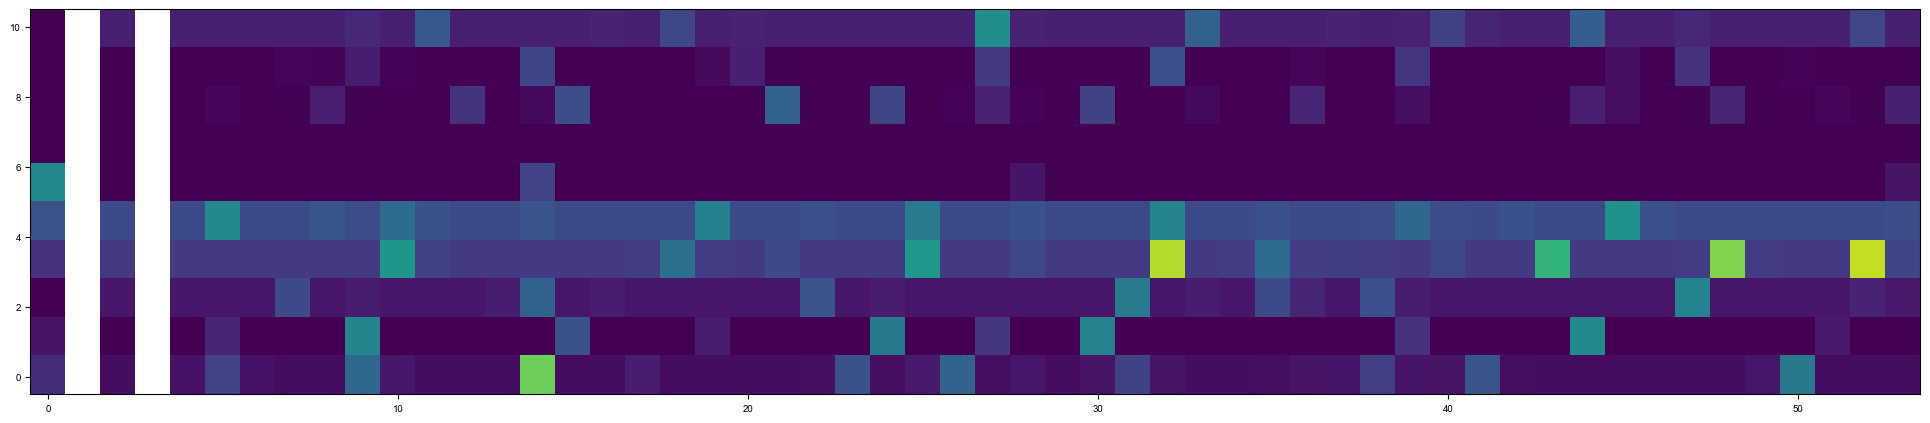

In [20]:
# Show result of simulation
# this shows in the first column the starting state (lambda(t-1)),
# followed by a column for the expected state after interactions (lambda(t)) without intrinsic waves,
# and then many sampled instances of this state with the intrinsic waves.

n_show = 50
extent = np.array([3.5, n_show + 3.5, -0.5, n_h + 0.5])
extent2 = np.array([-0.5, 0.5, -0.5, n_h + 0.5])

batch = 4
l_interact = torch.zeros_like(l_init[:, batch])

for h in range(n_h):
    l_interact[h] = torch.sum(U_original[:, h] * l_init[:, batch])
    
l_interact = s_modified.constraints(l_interact, **s_modified.kwargs)

plt.figure(figsize = (n_show/5, 2.5))

# Show initial state and interacted state without background activity
plt.imshow(np.array([l_init[:, batch].numpy()]).T, extent=extent2, vmin=0, vmax=1)
plt.imshow(np.array([l_interact.numpy()]).T, extent=extent2 + [2, 2, 0, 0], vmin=0, vmax=1)

# Show some instances with background activity
plt.imshow(s_modified.population_waves_interact[:, 1:n_show+1, batch], extent=extent, vmin=0, vmax=1)

plt.xlim([extent2[0], extent[1]])

plt.text(0, 10.75, 'Initial wave', ha='left', fontsize=8, rotation=45)
plt.text(2, 10.75, 'Interaction', ha='left', fontsize=8, rotation=45)
plt.text(10, 10.75, 'Interaction + background waves', fontsize=8)

plt.show()